In [1]:
import numpy as np
import pandas as pd
import os, re, boto3
from botocore.handlers import disable_signing
import matplotlib.pyplot as plt
%matplotlib inline

### Processing Test

* Consolidating the returned CSVs into one is relatively painless
* Main issue is that for some reason the time is still in GMT, and needs 5 hours in milliseconds subtracted from the epoch
* Validating against [Weather Underground read from O'Hare](https://www.wunderground.com/history/airport/KORD/2016/8/12/DailyHistory.html?req_city=Chicago+O%27Hare&req_state=IL&req_statename=&reqdb.zip=60666&reqdb.magic=8&reqdb.wmo=99999&MR=1)

In [2]:
s3_client = boto3.client('s3')
resource = boto3.resource('s3')
# Disable signing for anonymous requests to public bucket
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

def file_list(client, bucket, prefix=''):
    paginator = client.get_paginator('list_objects')
    for result in client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')['Contents']:
        yield result.get('Key')

gen_s3_files = list(file_list(s3_client, 'nexrad-etl', prefix='test-aug3/'))

for i, f in enumerate(gen_s3_files):
   s3_client.download_file('nexrad-etl',f,'test-aug3/nexrad{}.csv'.format(i))

folder_files = os.listdir(os.path.join(os.getcwd(), 'test-aug3'))
nexrad_df_list = list()
for f in folder_files:
    if f.endswith('.csv'):
        try:
            nexrad_df_list.append(pd.read_csv('test-aug3/{}'.format(f)))
        except:
            #print(f)
            pass
print(len(nexrad_df_list))

193


In [36]:
merged_nexrad = pd.concat(nexrad_df_list)
merged_nexrad['timestamp'] = pd.to_datetime(((merged_nexrad['timestamp'] / 1000) - (5*3600*1000)), unit='ms')
#merged_nexrad['timestamp'] = pd.to_datetime(merged_nexrad['timestamp'] / 1000, unit='ms')
merged_nexrad = merged_nexrad.set_index(pd.DatetimeIndex(merged_nexrad['timestamp']))
merged_nexrad = merged_nexrad.sort_values('timestamp')
merged_nexrad = merged_nexrad.fillna(0.0)
# Get diff between previous two reads
merged_nexrad['diff'] = merged_nexrad['timestamp'].diff()
merged_nexrad = merged_nexrad[1:]
print(merged_nexrad.shape)

(648, 61)


In [22]:
merged_nexrad.index.min()

Timestamp('2016-08-11 11:45:44')

In [23]:
merged_nexrad['diff'] = (merged_nexrad['diff'] / np.timedelta64(1, 'm')).astype(float) / 60
merged_nexrad.head()

,timestamp,60601,60655,60651,60609,60625,60624,60631,60626,60613,...,60646,60617,60623,60636,60634,60659,60607,60654,60657,diff
2016-08-11 11:45:44,2016-08-11 11:45:44,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.080000
2016-08-11 11:50:33,2016-08-11 11:50:33,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.748783,0.0,0.0,0.0,0.0,0.000000,0.0,0.080278
2016-08-11 11:55:21,2016-08-11 11:55:21,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.080000
2016-08-11 12:00:10,2016-08-11 12:00:10,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.929194,0.0,0.080278
2016-08-11 12:04:58,2016-08-11 12:04:58,0.0,0.748783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.080000


In [24]:
aug_day_ohare = merged_nexrad['2016-08-12'][['timestamp','60666','diff']]
aug_day_ohare.head()

,timestamp,60666,diff
2016-08-12 00:02:58,2016-08-12 00:02:58,0.0,0.069167
2016-08-12 00:07:08,2016-08-12 00:07:08,0.0,0.069444
2016-08-12 00:11:17,2016-08-12 00:11:17,0.0,0.069167
2016-08-12 00:15:26,2016-08-12 00:15:26,0.0,0.069167
2016-08-12 00:19:35,2016-08-12 00:19:35,0.0,0.069167


In [25]:
aug_day_ohare['60666'] = (aug_day_ohare['60666']*aug_day_ohare['diff'])/25.4
aug_day_ohare.head()

,timestamp,60666,diff
2016-08-12 00:02:58,2016-08-12 00:02:58,0.0,0.069167
2016-08-12 00:07:08,2016-08-12 00:07:08,0.0,0.069444
2016-08-12 00:11:17,2016-08-12 00:11:17,0.0,0.069167
2016-08-12 00:15:26,2016-08-12 00:15:26,0.0,0.069167
2016-08-12 00:19:35,2016-08-12 00:19:35,0.0,0.069167


### NEXRAD at O'Hare Zip 60666

0.956272464747


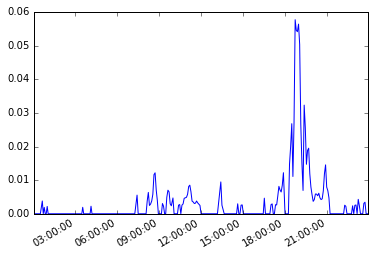

In [51]:
# Checking against Weather Underground read for O'Hare on this day
print(aug_day_ohare['60666'].sum())
aug_day_ohare['60666'].plot()

### Wunderground

0.96


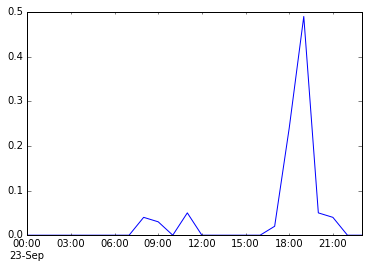

In [50]:
wunderground = pd.read_csv('test-aug3/aug-12.csv')
wunderground['PrecipitationIn'] = wunderground['PrecipitationIn'].fillna(0.0)
wunderground['TimeCDT'] = pd.to_datetime(wunderground['TimeCDT'])
wunderground = wunderground.set_index(pd.DatetimeIndex(wunderground['TimeCDT']))
wund_hour = wunderground['PrecipitationIn'].resample('1H').max()
print(wund_hour.sum())
wund_hour.plot()